In [1]:
from google.colab import drive
drive.mount('/content/drive')

# Uninstall potentially incompatible versions
!pip uninstall -y flwr numpy

# flwr>=1.10.0 is needed for compatibility with NumPy 2.0 (and Python 3.12).
!pip install -q numpy==2.0.0
!pip install -q 'flwr[simulation]>=1.10.0' tensorflow scikit-learn pandas


Mounted at /content/drive
Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 120.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 727.1/727.1 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.4/71.4 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 103.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 95.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.1/250.1 kB 20.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydrive2 1.21.3 requires cryptography<44, but you have cryp

In [2]:
import flwr as fl
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

# Uninstall numpy and related libraries that might have conflicting versions
# It's important to uninstall scipy explicitly to ensure a clean slate.
!pip uninstall -y numpy scikit-learn tensorflow scipy

# Install compatible numpy first
!pip install -q numpy==2.0.0

# Then install scipy, which should be able to resolve to a version compatible with numpy 2.0.0
!pip install -q scipy

# Then install scikit-learn, which depends on scipy and numpy
!pip install -q scikit-learn

# Finally, install tensorflow, which also depends on numpy
!pip install -q tensorflow

# Re-import numpy after re-installation
import numpy as np

Found existing installation: numpy 2.0.0
Uninstalling numpy-2.0.0:
  Successfully uninstalled numpy-2.0.0
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: scipy 1.16.3
Uninstalling scipy-1.16.3:
  Successfully uninstalled scipy-1.16.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pysal 25.7 requires scikit-learn>=1.1, which is not installed.
pysal 25.7 requires scipy>=1.8, which is not installed.
matplotlib-venn 1.1.2 requires scipy, which is not installed.
jax 0.7.2 requires scipy>=1.13, which is not installed.
statsmodels 0.14.6 requires scipy!=1.9.2,>=1.8, which is not installed.
access 1.1.10.post3 requires scipy>=1.14.1, which 

In [3]:
X = pd.read_csv("/content/drive/MyDrive/UNSW_X_preprocessed.csv")
y = pd.read_csv("/content/drive/MyDrive/UNSW_y.csv")

# If y is a DF with one column
if y.shape[1] == 1:
    y = y.iloc[:, 0]

X = X.values.astype("float32")
y = y.values.astype("int32")

print(X.shape, y.shape)


(82332, 18) (82332,)


In [4]:
X_train_all, X_test, y_train_all, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train_all.shape, "Test:", X_test.shape)


Train: (65865, 18) Test: (16467, 18)


In [5]:
NUM_CLIENTS = 10

# Shuffle indices
rng = np.random.RandomState(42)
indices = np.arange(len(X_train_all))
rng.shuffle(indices)

client_splits = np.array_split(indices, NUM_CLIENTS)

client_data = []
for i, idxs in enumerate(client_splits):
    client_data.append((X_train_all[idxs], y_train_all[idxs]))
    print(f"Client {i} -> {len(idxs)} samples")


Client 0 -> 6587 samples
Client 1 -> 6587 samples
Client 2 -> 6587 samples
Client 3 -> 6587 samples
Client 4 -> 6587 samples
Client 5 -> 6586 samples
Client 6 -> 6586 samples
Client 7 -> 6586 samples
Client 8 -> 6586 samples
Client 9 -> 6586 samples


In [6]:
def create_model(input_dim):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(2, activation='softmax')  # binary classification
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

input_dim = X.shape[1]


In [7]:
class FLClient(fl.client.NumPyClient):
    def __init__(self, X, y):
        self.model = create_model(input_dim)
        self.X = X
        self.y = y

    def get_parameters(self, config=None):
        return self.model.get_weights()

    def set_parameters(self, parameters):
        self.model.set_weights(parameters)

    def fit(self, parameters, config=None):
        self.set_parameters(parameters)
        self.model.fit(self.X, self.y, epochs=10, batch_size=32, verbose=0)
        return self.get_parameters(), len(self.X), {}

    def evaluate(self, parameters, config=None):
        self.set_parameters(parameters)
        loss, acc = self.model.evaluate(self.X, self.y, verbose=0)
        return loss, len(self.X), {"accuracy": acc}


In [8]:
best_acc = 0
patience = 2
wait = 0

In [9]:
def global_evaluate(server_round, parameters, config):
    global best_acc, wait

    model = create_model(X_test.shape[1])
    model.set_weights(parameters)
    loss, acc = model.evaluate(X_test, y_test, verbose=0)

    if acc > best_acc:
        best_acc = acc
        wait = 0
    else:
        wait += 1

    if wait >= patience:
        print("🛑 Early stopping triggered at round", server_round)
        raise StopIteration

    return loss, {"accuracy": acc}

In [10]:
strategy = fl.server.strategy.FedAvg(
    min_fit_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    fraction_fit=1.0,
    evaluate_fn=global_evaluate
)

In [11]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

def evaluate_round(server_round, parameters, config):
    model = create_model(X_test.shape[1])
    model.set_weights(parameters)

    y_pred = np.argmax(model.predict(X_test, verbose=0), axis=1)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"\n Round {server_round} Results")
    print(f"Accuracy  : {acc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall    : {rec:.4f}")
    print(f"F1-score  : {f1:.4f}")

    return 0.0, {
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }


In [12]:
!pip install -q ray

In [29]:
def client_fn(cid):
    cid = int(cid)
    Xc, yc = client_data[cid]
    return FLClient(Xc, yc)

strategy = fl.server.strategy.FedAvg(
    min_fit_clients=NUM_CLIENTS,
    min_available_clients=NUM_CLIENTS,
    fraction_fit=1.0
)

history = fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=NUM_CLIENTS,
    config=fl.server.ServerConfig(num_rounds=5),
    strategy=strategy,
)


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=5, no round_timeout
2026-01-02 18:45:04,728	INFO worker.py:2012 -- Started a local Ray instance.
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'object_store_memory': 3963627110.0, 'node:172.28.0.12': 1.

In [30]:
# Collect final client weights
weights_list = []
for c in range(NUM_CLIENTS):
    Xc, yc = client_data[c]
    client = FLClient(Xc, yc)
    weights_list.append(client.get_parameters())

# Average weights
avg_weights = []
for weights in zip(*weights_list):
    avg_weights.append(np.mean(np.array(weights), axis=0))

global_model = create_model(input_dim)
global_model.set_weights(avg_weights)

print("Global model built from aggregated client weights.")


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Global model built from aggregated client weights.


In [31]:
pred_probs = global_model.predict(X_test)
preds = np.argmax(pred_probs, axis=1)

print(classification_report(y_test, preds, digits=4))

acc = accuracy_score(y_test, preds)
prec = precision_score(y_test, preds, zero_division=0)
rec = recall_score(y_test, preds, zero_division=0)
f1 = f1_score(y_test, preds, zero_division=0)

print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1:", f1)


515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 805us/step
              precision    recall  f1-score   support

           0     0.5838    0.7139    0.6423      7400
           1     0.7146    0.5845    0.6430      9067

    accuracy                         0.6427     16467
   macro avg     0.6492    0.6492    0.6427     16467
weighted avg     0.6558    0.6427    0.6427     16467

Accuracy: 0.6426792979899192
Precision: 0.7145746258595119
Recall: 0.5845373331862799
F1: 0.6430478039310847


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [32]:
results_df = pd.DataFrame(X_test, columns=[f"f{i}" for i in range(X_test.shape[1])])
results_df["true"] = y_test
results_df["pred"] = preds
results_df["action"] = results_df["pred"].apply(lambda x: "BLOCK" if x == 1 else "ALLOW")

blocked = results_df[results_df["action"] == "BLOCK"]
blocked_path = "/content/drive/MyDrive/UNSW_blocked_predictions_FL2.csv"
blocked.to_csv(blocked_path, index=False)

print(f"Blocked flows saved to: {blocked_path}")
print("Total blocked:", len(blocked))
print("True attacks blocked:", sum((results_df["true"]==1) & (results_df["action"]=="BLOCK")))
print("False blocks:", sum((results_df["true"]==0) & (results_df["action"]=="BLOCK")))


Blocked flows saved to: /content/drive/MyDrive/UNSW_blocked_predictions_FL2.csv
Total blocked: 7417
True attacks blocked: 5300
False blocks: 2117


/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [17]:
!pip install seaborn matplotlib scikit-learn

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
import numpy as np

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


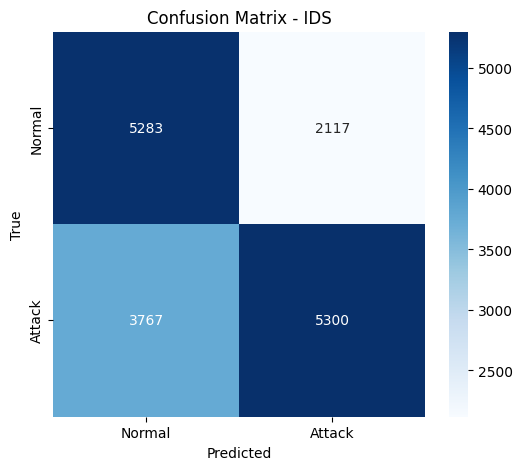

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [34]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal", "Attack"],
            yticklabels=["Normal", "Attack"])
plt.title("Confusion Matrix - IDS")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

515/515 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step


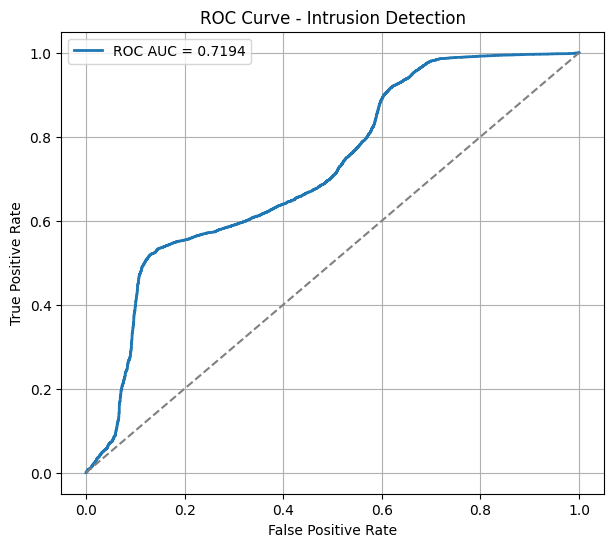

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [35]:
pred_probs = global_model.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, pred_probs[:,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,6))
plt.plot(fpr, tpr, lw=2, label=f"ROC AUC = {roc_auc:.4f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Intrusion Detection")
plt.legend()
plt.grid(True)
plt.show()

# Task
Uninstall numpy, scikit-learn, tensorflow, and scipy, then install numpy==2.0.0, scipy==1.13.1, scikit-learn, and tensorflow to resolve dependency conflicts and ensure compatibility with Python 3.12.

## uninstall_dependencies

### Subtask:
Uninstall numpy, scikit-learn, tensorflow, and scipy to ensure a clean slate for dependency resolution.


**Reasoning**:
To ensure a clean environment for dependency resolution, I will uninstall the specified packages: numpy, scikit-learn, tensorflow, and scipy.



In [ ]:
import sys

# Uninstall potentially incompatible versions
!pip uninstall -y numpy scikit-learn tensorflow scipy

print("Uninstallation complete.")

Found existing installation: numpy 2.1.3
Uninstalling numpy-2.1.3:
  Successfully uninstalled numpy-2.1.3
Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1
Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0
Found existing installation: scipy 1.16.3
Uninstalling scipy-1.16.3:
  Successfully uninstalled scipy-1.16.3
Uninstallation complete.


**Reasoning**:
Now that the potentially conflicting packages have been uninstalled, I will install a compatible version of NumPy (2.0.0) first, as it is a fundamental dependency for many scientific libraries.



In [ ]:
import sys

# Install compatible numpy first
!pip install -q numpy==2.0.0

print("Numpy 2.0.0 installation complete.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.9/60.9 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.0/19.0 MB 54.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
osqp 1.0.5 requires scipy>=0.13.2, which is not installed.
segregation 2.5.3 requires scikit-learn>=0.21.3, which is not installed.
segregation 2.5.3 requires scipy, which is not installed.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, which is not installed.
mlxtend 0.23.4 requires scipy>=1.2.1, which is not installed.
shap 0.50.0 requires scikit-learn, which is not installed.
shap 0.50.0 requires scipy, which is not installed.
jaxlib 0.7.2 requires scipy>=1.13, which is not installed.
missingno 0.5.2 requires scipy, which is not installed.
sklearn-pandas 2.2.0 requires scikit-learn>=0.23.0, which is not installed.
sklearn-pandas 2.2.0 requires scipy>=1.5.1,

**Reasoning**:
With NumPy installed, I will now install `scipy==1.13.1` to maintain compatibility and fulfill its dependencies for subsequent installations.



In [ ]:
import sys

# Then install scipy, which should be able to resolve to a version compatible with numpy 2.0.0
!pip install -q scipy==1.13.1

print("Scipy 1.13.1 installation complete.")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.2/38.2 MB 19.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
segregation 2.5.3 requires scikit-learn>=0.21.3, which is not installed.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, which is not installed.
shap 0.50.0 requires scikit-learn, which is not installed.
sklearn-pandas 2.2.0 requires scikit-learn>=0.23.0, which is not installed.
dopamine-rl 4.1.2 requires tensorflow>=2.2.0, which is not installed.
fastai 2.8.5 requires scikit-learn, which is not installed.
yellowbrick 1.5 requires scikit-learn>=1.0.0, which is not installed.
tsfresh 0.21.1 requires scikit-learn>=0.22.0, which is not installed.
spopt 0.7.0 requires scikit-learn>=1.4.0, which is not installed.
imbalanced-learn 0.14.0 requires scikit-learn<2,>=1.4

**Reasoning**:
Now that NumPy and SciPy are installed, I will install `scikit-learn` to fulfill the dependency requirements, as it relies on both previously installed libraries.



In [ ]:
import sys

# Then install scikit-learn, which depends on scipy and numpy
!pip install -q scikit-learn

print("Scikit-learn installation complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 83.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsfresh 0.21.1 requires scipy>=1.14.0; python_version >= "3.10", but you have scipy 1.13.1 which is incompatible.
Scikit-learn installation complete.


**Reasoning**:
Finally, with NumPy, SciPy, and Scikit-learn installed, I will install `tensorflow` to complete the dependency resolution. This order of installation helps in resolving potential conflicts and ensuring compatibility.



In [ ]:
import sys

# Finally, install tensorflow, which also depends on numpy
!pip install -q tensorflow

print("Tensorflow installation complete.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 866.3 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.19.0 requires tensorflow<2.20,>=2.19.0, but you have tensorflow 2.20.0 which is incompatible.
tf-keras 2.19.0 requires tensorflow<2.20,>=2.19, but you have tensorflow 2.20.0 which is incompatible.
tensorflow-decision-forests 1.12.0 requires tensorflow==2.19.0, but you have tensorflow 2.20.0 which is incompatible.
Tensorflow installation complete.
